# COMP47700-Speech and Audio Project
**Team Members:** Zairui Zhang and Ao Peng

### Project Introduction


The project is designed to enhance real-time communication by developing an adaptive audio processing system. This system aims to significantly improve speech quality and intelligibility in noisy and reverberant environments. Given the increasing prevalence of online meetings, this enhancement is vital as it can greatly improve sound quality, reduce listening difficulties, and boost communication efficiency. The system is also applicable for real-time audio transcription and live voice transmission via social media applications.

### Project Goals

1\. **Explore and Adapt Audio Processing Techniques:** Investigate existing techniques such as noise suppression, echo cancellation, and reverberation control. Adapt and reimplement these methods into Python programs tailored for specific application scenarios.

2\. **Train/Test with New Data:** Utilize newly collected datasets, particularly from meeting recordings or live speech transmissions with noise and reverberation. Implement machine learning or deep learning methods to automatically identify and remove these disturbances.

3\. **Improve Audio Quality:** The ultimate goal is to enhance audio clarity in remote communications, whether in large conference rooms or noisy public spaces. This not only betters the user's listening experience but also increases the accuracy of speech recognition software.

### Data Requirements

- **Noisy Speech Data:** Speech records in various noisy backgrounds such as streets, cafes, and offices. Essential for training and testing noise reduction algorithms.

- **Speech Data with Reverberation:** Captured in different indoor settings to simulate real-world reverberation, aiding in training technologies to manage these effects.

- **Clean Speech Data:** Clear speech recordings used to compare and evaluate the effectiveness of the processed audio against the unprocessed baseline.


## Current Progress

We have begun by implementing several foundational audio processing functions using Python. Here's a brief overview of our accomplishments so far:

- **Noise Reduction:** Techniques like spectral subtraction have been utilized to reduce background noise in audio files.

- **Silence Detection and Removal:** We're able to trim parts of the audio that are silent or nearly silent, which helps in focusing on the meaningful audio content.

- **Audio Normalization:** The audio volume is normalized to ensure consistency in the loudness of the output across different files.

- **Pre-emphasis Filtering:** This process enhances the clarity of speech by amplifying the high-frequency components.

### Next Steps

- **Optimizing Algorithms:** Further refine the algorithms to improve their effectiveness in real-world noisy and reverberant environments.

- **Implementing Machine Learning Models:** Plan to train models that can predict and mitigate undesirable audio properties effectively, enhancing the overall speech quality in real-time communication scenarios.

### Evaluation Criteria

- **Audio Quality Improvement:** The processed audio should demonstrate a significant improvement in clarity and quality.

- **Effectiveness in Real-time Scenarios:** The processing scheme should be effective in actual communication situations.

- **User Feedback:** Positive feedback will indicate the success of the audio processing enhancements in practical applications.

By adhering to these objectives and continuously refining our methods, we aim to validate the effectiveness of our proposed solution for improving audio quality in digital communications.

In [44]:
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

def normalize_audio(audio):
    """
    Normalize an audio signal to the range [-1, 1].
    """
    max_value = np.max(np.abs(audio))
    if max_value > 0:
        audio = audio / max_value
    return audio

def vad(audio, sr, frame_length=0.02, hop_length=0.01, threshold=0.01):
    """
    A simple energy-based VAD.
    """
    frame_samples = int(frame_length * sr)
    hop_samples = int(hop_length * sr)
    energy = np.array([
        np.sum(np.square(audio[i:i+frame_samples]))
        for i in range(0, len(audio) - frame_samples, hop_samples)
    ])
    return energy > threshold

def adaptive_noise_estimation(audio, sr, frame_length=2048, hop_length=512, smoothing_frames=10):
    """
    Estimate noise using an adaptive approach with simulated VAD and temporal smoothing.
    """
    is_speech = vad(audio, sr, frame_length=frame_length/sr, hop_length=hop_length/sr)
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
    noise_frames = frames[:, ~is_speech[:frames.shape[1]]]  # Use VAD to filter noise frames
    if noise_frames.size == 0:
        # Return a flat spectrum if no noise frames are detected
        return np.ones((int(frame_length // 2 + 1), 1)) * 0.001

    noise_stft = librosa.stft(noise_frames.flatten(), n_fft=frame_length, hop_length=hop_length)
    noise_spectrum = np.mean(np.abs(noise_stft), axis=1, keepdims=True)

    # Check if there are enough frames to apply smoothing
    if noise_spectrum.shape[1] < 2 * smoothing_frames + 1:
        return noise_spectrum

    # Apply temporal smoothing
    smoothed_spectrum = np.copy(noise_spectrum)
    for i in range(smoothing_frames, noise_spectrum.shape[1] - smoothing_frames):
        smoothed_spectrum[:, i] = np.mean(noise_spectrum[:, i-smoothing_frames:i+smoothing_frames+1], axis=1)

    return np.mean(smoothed_spectrum, axis=1, keepdims=True)

def spectral_subtraction(audio, sr, over_subtraction_factor=1.2, spectral_floor=0.05):
    """
    Perform spectral subtraction using adaptive noise estimation.
    Apply an over-subtraction factor and a spectral floor to reduce musical noise.
    """
    n_fft = 2048
    hop_length = 512
    S_full, phase = librosa.magphase(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    noise_spectrum = adaptive_noise_estimation(audio, sr)

    # Applying over-subtraction factor and spectral floor
    S_clean = np.maximum(S_full - over_subtraction_factor * noise_spectrum, spectral_floor)
    y_clean = librosa.istft(S_clean * phase, hop_length=hop_length)
    return y_clean

def detect_silence_and_trim(audio, sr):
    """
    Detect and remove silence from an audio signal.
    """
    # Using a threshold to detect silence
    trim_audio, index = librosa.effects.trim(audio, top_db=20)
    return trim_audio

def pre_emphasis_filter(audio, pre_emphasis=0.97):
    """
    Apply a pre-emphasis filter to the audio signal.
    """
    return np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

def process_audio_file(filepath, sr=None):
    """
    Process an individual audio file.
    """
    audio, sr = librosa.load(filepath, sr=sr)
    # Noise reduction with explicit parameters
    audio_nr = spectral_subtraction(audio, sr, over_subtraction_factor=1.2, spectral_floor=0.05)
    # Silence removal
    audio_silence_removed = detect_silence_and_trim(audio_nr, sr)
    # Normalization
    audio_normalized = normalize_audio(audio_silence_removed)
    # Pre-emphasis
    audio_preemphasized = pre_emphasis_filter(audio_normalized)
    return audio_preemphasized, sr


def process_directory(root_directory, noise_type, db_level):
    """
    Process a directory of audio files with noise reduction, silence removal, normalization, and pre-emphasis.
    """
    # Directory paths
    wav_directory = os.path.join(root_directory, f"{noise_type}_{db_level}dB", "wav")
    output_directory = os.path.join(root_directory, f"processed_{noise_type}_{db_level}dB")
    os.makedirs(output_directory, exist_ok=True)
    
    # Process each audio file in the directory
    for filename in os.listdir(wav_directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(wav_directory, filename)
            audio_processed, sr = process_audio_file(filepath)
            output_path = os.path.join(output_directory, filename)
            sf.write(output_path, audio_processed, sr)

            
# (Only if you want to visualize, otherwise remove this part)
def plot_waveforms(original_audio, processed_audio, sr):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(original_audio, sr=sr, alpha=0.5)
    plt.title('Original Audio')
    plt.ylim([-1, 1])
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(processed_audio, sr=sr, alpha=0.5)
    plt.title('Processed Audio')
    plt.ylim([-1, 1])
    plt.show()

In [45]:
from IPython.display import Audio

# Define the root directory for the NOIZEUS dataset
root_directory = 'NOIZEUS'
noise_types = ['airport', 'babble', 'car', 'exhibition', 'restaurant', 'station', 'street', 'train']
db_levels = ['0', '5', '10']

# Process directories first
for noise_type in noise_types:
    for db_level in db_levels:
        process_directory(root_directory, noise_type, db_level)

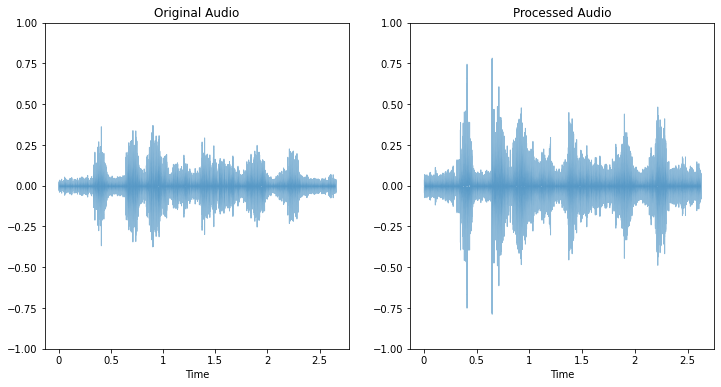

In [46]:
# Original audio directory
original_directory = os.path.join(root_directory, f"{noise_types[0]}_{db_levels[0]}dB", "wav")

# Path to the processed audio files
processed_directory = os.path.join(root_directory, f"processed_{noise_types[0]}_{db_levels[0]}dB")

# Load an example processed file
example_filenames = os.listdir(processed_directory)
if example_filenames:
    example_filename = example_filenames[0]
    original_path = os.path.join(original_directory, example_filename)
    processed_path = os.path.join(processed_directory, example_filename)
    
    # Load audio files
    original_audio, sr = librosa.load(original_path, sr=None)
    processed_audio, sr = librosa.load(processed_path, sr=None)

    # Plot the waveform of the original and processed audio
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(original_audio, sr=sr, alpha=0.5)
    plt.title('Original Audio')
    plt.ylim([-1, 1])
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(processed_audio, sr=sr, alpha=0.5)
    plt.title('Processed Audio')
    plt.ylim([-1, 1])
    plt.show()
    
    # Play the original audio
    display(Audio(data=original_audio, rate=sr))
    # Play the processed (normalized) audio
    display(Audio(data=processed_audio, rate=sr))